<a href="https://colab.research.google.com/github/GiuliaLanzillotta/exercises/blob/master/Signal_processing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Signal processing 

Today we're going to dive into signal processing techniques (*FFT, DCT, Wavelets transform, ...*) with a focus on data compression.<br>

Data compression is a fascinating problem, deeply rooted in *information theory*. <br>
The various data compression techniques developed are based on the idea that each signal can be viewed as the *linear combination* of some simpler signals. Underlying this idea is the assumption that each signal was generated by a combination of simple processes. <br>
Finding a solution to the data compression problem then can be decomposed in 2 sub-problems: 
- indentifying a set of base signals that can have generated the signal we're observing (different solutions to this problem lead to different techniques) ;
- finding the linear combination coefficients that can express this signal with respect to the selected base.

Today we're focusing on identifying signal bases that can lead to **sparse signal representations**. As you can imagine, a sparse representation makes it easier to compress the original signal. 



## Haar Wavelets 

The first signal processing technique we're going to look at is the Wavelets transofrm. In particular we'll use a discrete type of wavelet: the *Haar Wavelet*. 

![Haar](http://fourier.eng.hmc.edu/e161/lectures/figures/Haar_8.gif)

The Haar Wavelets are a parametric signal basis, uniquely identified by a dimension parameter. You have to think of this dimension parameter as the discretization level of your signal basis. Using a basis of dimension 4 means that you'll span the input signal with 4 different waves, one of which is always just a constant.All the other basis vectors are obtained by scaling by power of two and translating the mother wavelet (top row, second figure).

In [0]:
import numpy as np
import pylab as pl
import matplotlib.pyplot as plt

In [0]:
def haarMatrix(n):
  """The algorithm to compute recursively the haar matrix can be 
  found here : https://iopscience.iop.org/article/10.1088/0305-4470/36/24/316/pdf,
  equations 9 and 10"""
  # Allow only size n of power 2
  n = 2**np.ceil(np.log2(n))

  if n > 2: h = haarMatrix(n / 2)
  else: return np.array([[1, 1], [1, -1]])

  # calculate upper haar part
  h_n = np.kron(h, [1, 1])
  
  # calculate lower haar part 
  h_i = np.sqrt(n/2)*np.kron(np.eye(len(h)), [1, -1])

  # combine parts
  h = np.vstack((h_n, h_i))
  return h

In [3]:
haarMatrix(4)

array([[ 1.        ,  1.        ,  1.        ,  1.        ],
       [ 1.        ,  1.        , -1.        , -1.        ],
       [ 1.41421356, -1.41421356,  0.        , -0.        ],
       [ 0.        , -0.        ,  1.41421356, -1.41421356]])

Let's look at an Haar basis for a dimension of 16.

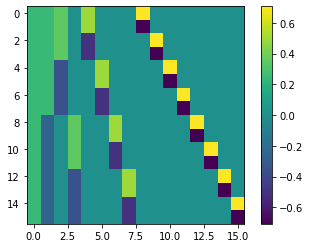

In [4]:
K = 16 
U = np.transpose(haarMatrix(K)/np.sqrt(K)) #the denominator scales the matrix to obtain an orthonormal basis 
plt.imshow(U, interpolation='nearest')
plt.colorbar()
plt.show()

You should look at the above plot column by column: each column represents a different wavelet.<br>
Let's try to look at them in a more wavy form. 

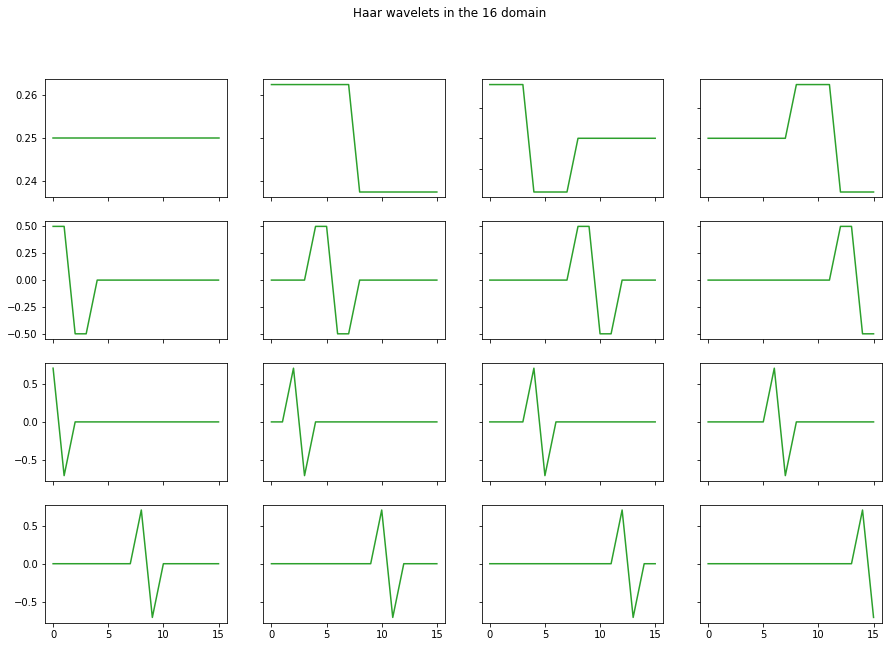

In [5]:
fig, axs = plt.subplots(4, 4, figsize=(15, 10))
fig.suptitle('Haar wavelets in the 16 domain')
for i in range(4):
  for j in range(4):
    axs[i,j].plot(U[:,i*4+j], 'tab:green')

for ax in fig.get_axes():
    ax.label_outer()

Before applying the transformation let's double check that our signal basis is effectively orthonormal. <br>
Checking orthornormality is simple: the product $U^TU$ should give us the identity $I_{16}$.

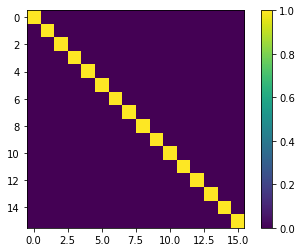

In [6]:
plt.imshow(np.dot(np.transpose(U),U), interpolation='nearest')
plt.colorbar()
plt.show()

### Applying the wavelet transform 

Now we'll hand-craft a signal to stury the effects of an Haar transform. Actually, we're going to build two different signals: a periodic one and a single-spike one, both corrupted by some Gaussian noise; and finally we're going to compare the results of the Haar transform in these two cases.

In [0]:
# we build a signal with length 128 
x = np.arange(0.1, 12.81, 0.1) 
h = np.zeros(128)
h[40:60] = 1
periodic = np.sin(x*3)*3
periodic = periodic
singlespike = np.sin(x)*h
aperiodic = singlespike *10 

Text(0.5, 1.0, 'Aperiodic')

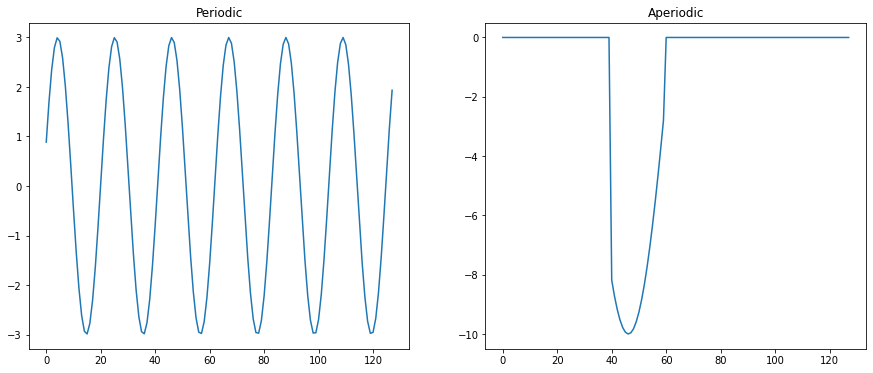

In [9]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(periodic)
ax1.set_title('Periodic')
ax2.plot(aperiodic)
ax2.set_title('Aperiodic')

We still need to add some noise. To have comparable results we'll add the same level of noise to both signals.

In [0]:
noise = np.random.normal(0,2,128)
signal1 = periodic + noise
signal2 = aperiodic + noise

Text(0.5, 1.0, 'Second signal')

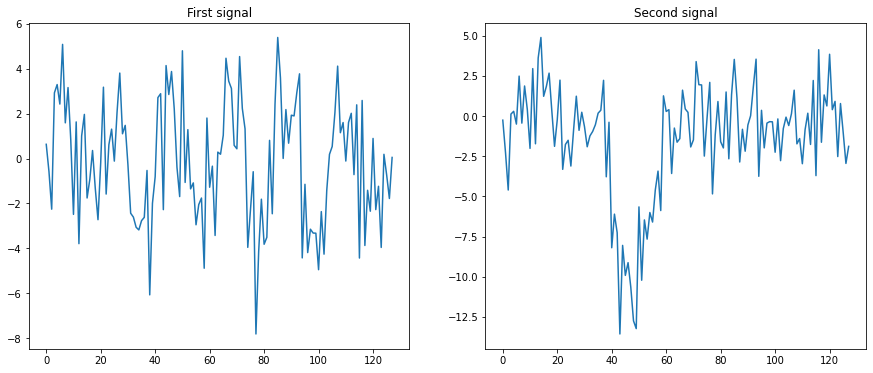

In [11]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(signal1)
ax1.set_title('First signal')
ax2.plot(signal2)
ax2.set_title('Second signal')

Now finally we can transform our inputs with our Haar wavelets.

In [0]:
U = np.transpose(haarMatrix(128)/np.sqrt(128))
spectrum1 = np.dot(np.transpose(U), signal1)
spectrum2 = np.dot(np.transpose(U), signal2)

Text(0.5, 1.0, 'Second spectrum')

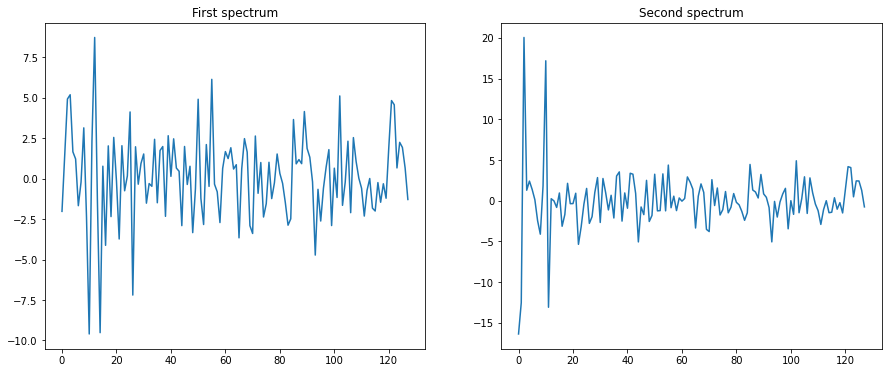

In [13]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(spectrum1)
ax1.set_title('First spectrum')
ax2.plot(spectrum2)
ax2.set_title('Second spectrum')

There seem to be two interesting spikes in the spectrum of the second signal, corresponding to two different base wavelets. 

### De-noising 

Now we'll try to denoise the signal by removing from the spectrum the low coefficients and re-transforming this filtered spectrum into the time domain. Easier done than said: since our transformation matrix is orthonormal we can easily obtain its inverse by the transpose operator. 

Text(0.5, 1.0, 'Second spectrum')

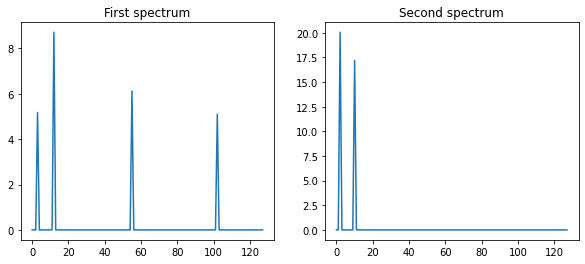

In [14]:
gamma = 5 # suppressing frequencies with amplitude less than 5 in the spectrum
spectrum1_copy = spectrum1.copy()
spectrum2_copy = spectrum2.copy()

spectrum1_copy[spectrum1_copy < gamma] = 0 
spectrum2_copy[spectrum2_copy < gamma] = 0

f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(spectrum1_copy)
ax1.set_title('First spectrum')
ax2.plot(spectrum2_copy)
ax2.set_title('Second spectrum')

In [0]:
signal1_denoised = np.dot(U,spectrum1_copy)
signal2_denoised = np.dot(U,spectrum2_copy)

Text(0.5, 1.0, 'Second signal -denoised')

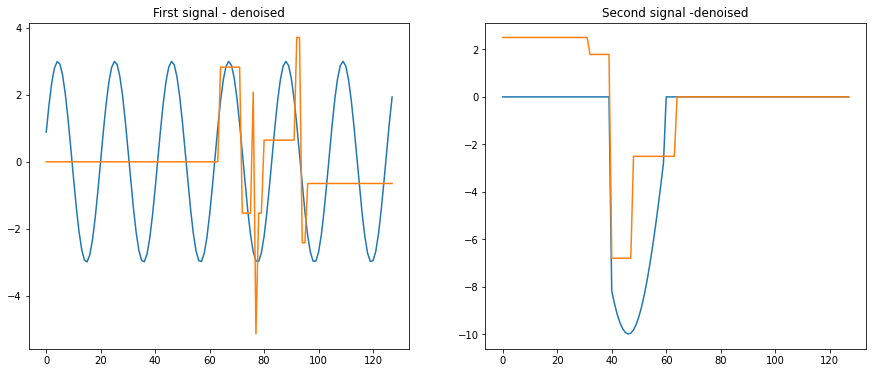

In [16]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(periodic)
ax1.set_title('First signal')
ax2.plot(aperiodic)
ax2.set_title('Second signal')
ax1.plot(signal1_denoised)
ax1.set_title('First signal - denoised')
ax2.plot(signal2_denoised)
ax2.set_title('Second signal -denoised')

The results above perfectly match the expectations: wavelets are not capable of capturing periodic trends, since they describe signals as linear combinations of localised bumps. On the other hand, wavelets can be very effective in detecting and describing aperiodic signals. 

## Fast Fourier Transform  (FFT) 

The Fourier transform uses as a basis a combination of sines and cosines waves. Being sines and cosines not localised in the time domain, the basic assumption underlying this set of techniques is that the observed signal is periodic.


In the following cells I'll repeat the transformation+denoising steps covered above for the DWT (discrete wavelet transform) to look at the differences in results. 


In [0]:
spectrum1_fft = np.abs(np.fft.fft(signal1))
spectrum2_fft = np.abs(np.fft.fft(signal2))

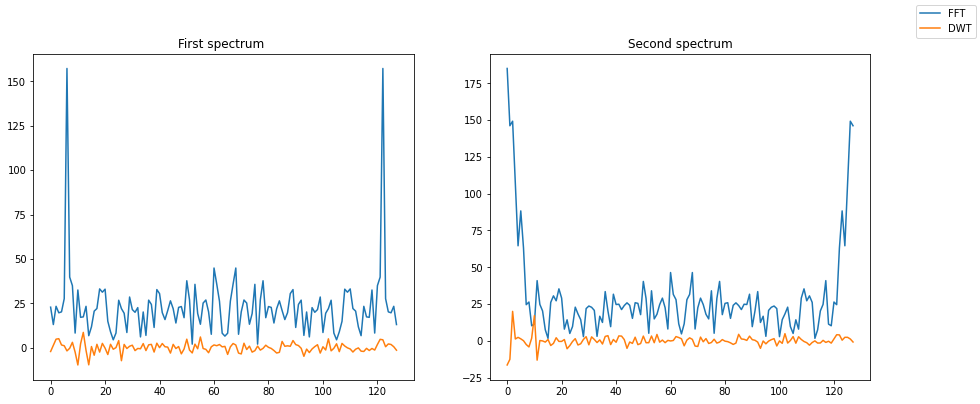

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(spectrum1_fft)
ax2.plot(spectrum2_fft)
ax1.plot(spectrum1)
ax1.set_title('First spectrum ')
ax2.plot(spectrum2)
ax2.set_title('Second spectrum')
f.legend(labels=("FFT","DWT"))

There are a pair of things worth noticing in the above plot: 
- the FFT puts a lot of weight on the high frequencies for both signals: the reason for this is that both sequences are limited in time and the instantaneous changes registered at the start and at the end of the signal are interpreted as an high frequency content. 
- the FFT identifies a frequency around 3 for the first signal that the DWT doesn't take into account 

Now let's denoise

Text(0.5, 1.0, 'Second spectrum')

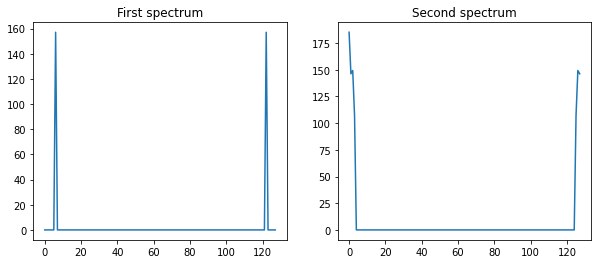

In [19]:
gamma = 100 # suppressing frequencies with amplitude less than 5 in the spectrum
spectrum1_fft_copy = spectrum1_fft.copy()
spectrum2_fft_copy = spectrum2_fft.copy()

spectrum1_fft_copy[spectrum1_fft_copy < gamma] = 0 
spectrum2_fft_copy[spectrum2_fft_copy < gamma] = 0


f, (ax1, ax2) = plt.subplots(1, 2, figsize=(10,4))
ax1.plot(spectrum1_fft_copy)
ax1.set_title('First spectrum')
ax2.plot(spectrum2_fft_copy)
ax2.set_title('Second spectrum')

In [0]:
signal1_denoised_fft = np.fft.ifft(spectrum1_fft_copy)
signal2_denoised_fft = np.fft.ifft(spectrum2_fft_copy)

/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: ComplexWarning: Casting complex values to real discards the imaginary part
  return array(a, dtype, copy=False, order=order)


Text(0.5, 1.0, 'Second signal -denoised')

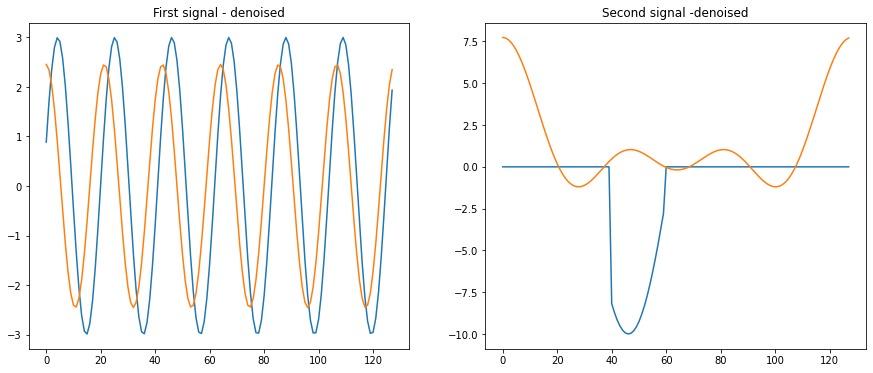

In [21]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,6))
ax1.plot(periodic)
ax1.set_title('First signal')
ax2.plot(aperiodic)
ax2.set_title('Second signal')
ax1.plot(signal1_denoised_fft)
ax1.set_title('First signal - denoised')
ax2.plot(signal2_denoised_fft)
ax2.set_title('Second signal -denoised')

As expected, we obtain opposite results if compared with the DWT: the FFT is perfectly capable of capturing a periodic trend, but it cannot be used to analyse localised signals. 

## Compressive sensing

The idea of compressive sensing is to apply the compression directly at the source: instead of measuring a D-dimensional signal to find its sparse representation afterwards, we want to collect a minimal number of measurements M << D from which we can directly reconstruct the sparse representation of the signal. 

Theory confirms that compressive sensing is possible: the minimal number of measurements M is $ c \: K \: log (\frac{D}{K}) $, where $D$ is the original dimension, $K$ is the sparsity factor and $c$ is a multiplicative constant factor.

Assuming that each measurement is a linear combination of the entries of the original signal $x$, finding $z$ (its sparse representation), given $y$ (the M-dimensional measurements vector) can be phrased as an optimization problem: 

$$ min \; \; ||z||_0$$ 
$$ s.t. \;\; WUz = y \; \; $$

where $W$ is the measurements transformation matrix, i.e. $y = Wx$, and $U$ is our dictionary, i.e $x = Uz$. 

Note that the above optimization problem is NP-Hard: to solve it we have to accept some compromises. The most common approaches either use a convex relaxation of the objective ($L_1$ norm instead of $L_0$), or apply a greedy optimization procedure (see the *Matching pursuit* algorithm). 
<br>
<br>

#### Enough with the theory
We'll now use the Haar wavelets dictionary as U, and we'll play a bit with this idea of compressive sensing. 

In [49]:
# generating randomly a sparse signal 
D = 32 # original dimension
z = np.random.randint(0,10,size=D) * np.random.randint(0,2,size=D)
z

array([0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 8, 2, 0, 1, 0, 0, 8, 0, 0, 9, 0, 6,
       8, 0, 9, 0, 3, 1, 0, 2, 0, 0])

In [88]:
K = np.sum([z!=0]) # sparsity factor
U = U = np.transpose(haarMatrix(D)/np.sqrt(D)) # dictionary
K

12

In [0]:
# obtaining x from z 
x = np.dot(U, z)
# obtaining y from x 
# we need to get M << D random directions, which we encode in 
# the measurement matrix W 
M = int(K*np.math.log(D/K)) # using the theorem with c = 1 
W = np.random.normal(size=(M,D)) # random directions 
y = np.dot(W,x)

Now let's do some plotting to have fun : 

Text(0.5, 1.0, 'Measurement - y')

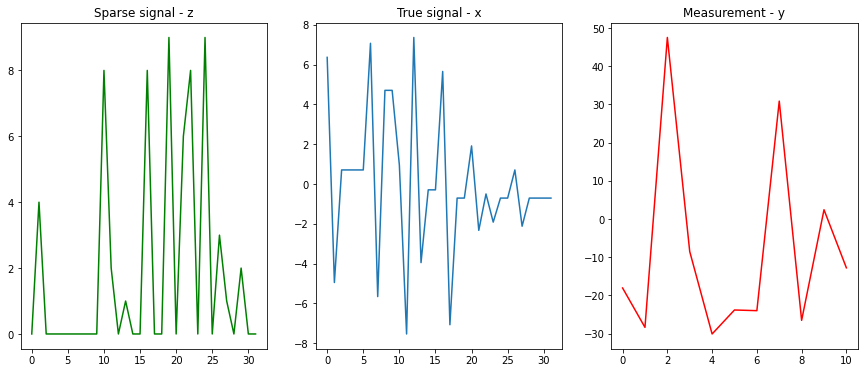

In [90]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))
ax1.plot(z, "g")
ax1.set_title('Sparse signal - z')
ax2.plot(x)
ax2.set_title('True signal - x')
ax3.plot(y, "r")
ax3.set_title('Measurement - y')

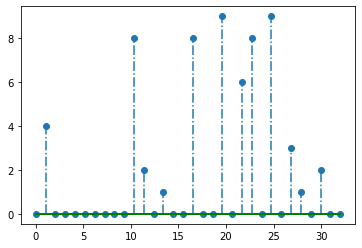

In [91]:
ax = np.linspace(0, D, D)
markerline, stemlines, baseline = plt.stem(ax, z, '-.', use_line_collection=True)
plt.setp(baseline, 'color', 'g', 'linewidth', 2)
plt.title="z"
plt.show()

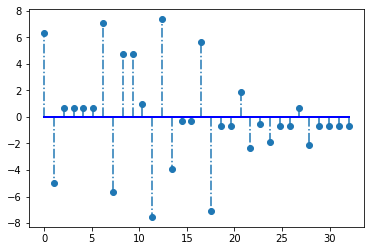

In [92]:
markerline, stemlines, baseline = plt.stem(ax, x, '-.', use_line_collection=True)
plt.setp(baseline, 'color', 'b', 'linewidth', 2)
plt.title="x"
plt.show()

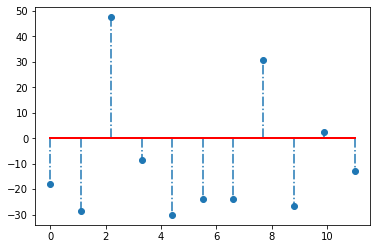

In [93]:
ax = np.linspace(0, M, M)
markerline, stemlines, baseline = plt.stem(ax, y, '-.', use_line_collection=True)
plt.setp(baseline, 'color', 'r', 'linewidth', 2)
plt.title="y"
plt.show()

Now let's have a look at the matrix $\theta = WU$ 

In [0]:
theta = np.dot(W,U)

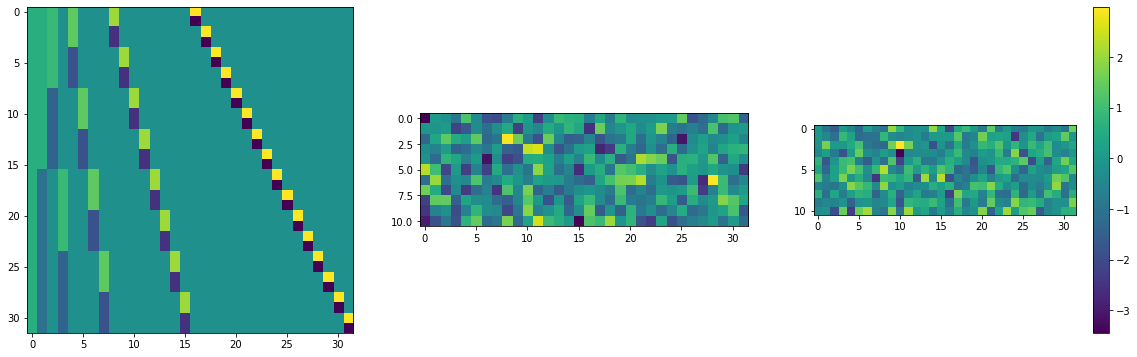

In [95]:
plt.subplots(1, 3, figsize=(20,6))
plt.subplot(1, 3, 1)
plt.imshow(U)
plt.subplot(1, 3, 2)
plt.imshow(W)
plt.subplot(1, 3, 3)
plt.imshow(theta)
plt.colorbar()
plt.show()

Now let's try to reconstruct x, given y .

We'll first try with least squares, i.e. the solution to the following problem : 

$$ \hat{z} = \; argmin_z \; || y - \theta z ||^2 $$ 

In [0]:
import sklearn.linear_model as linear_model

In [0]:
LS_model = linear_model.LinearRegression(fit_intercept=False)
z_hat = LS_model.fit(theta, y).coef_

Let's compare the results of Least Squares estimation with what we know to be the ground truth. 

In [0]:
x_hat = np.dot(U, z_hat)
y_hat = np.dot(theta, z_hat)

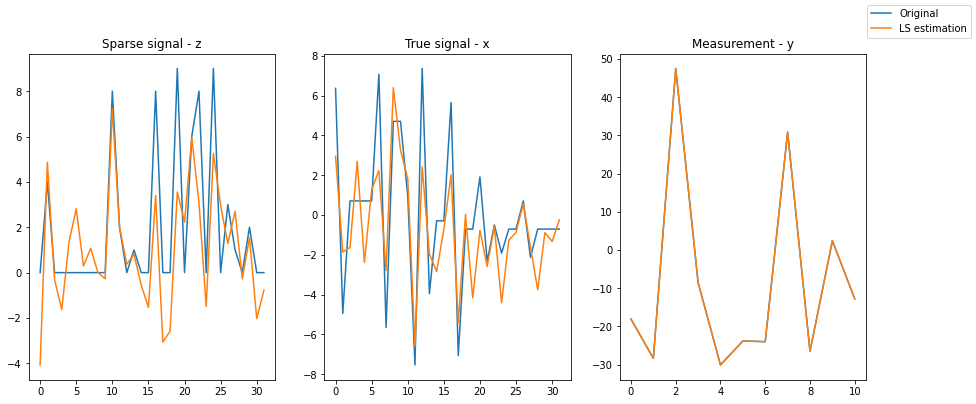

In [119]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))
ax1.plot(z)
ax1.plot(z_hat)
ax1.set_title('Sparse signal - z')
ax2.plot(x)
ax2.plot(x_hat)
ax2.set_title('True signal - x')
ax3.plot(y)
ax3.plot(y_hat)
ax3.set_title('Measurement - y')

f.legend(labels=("Original","LS estimation"))

As you can see, least squares does not a perfect job in estimating the coefficients of z. 

Let's now try with Lasso: 
$$ \hat{z} = \; argmin_z \; || y - \theta z ||^2 + \lambda \; ||z||_1$$ 

In [0]:
Lasso_model = linear_model.Lasso(alpha=1, fit_intercept=False)
z_hat_lasso = Lasso_model.fit(theta, y).coef_

In [0]:
x_hat_lasso = np.dot(U, z_hat_lasso)
y_hat_lasso = np.dot(theta, z_hat_lasso)

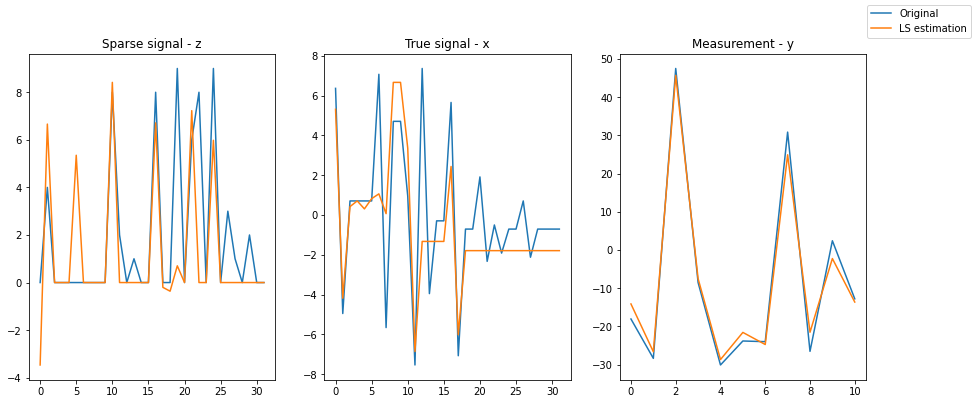

In [125]:
f, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15,6))
ax1.plot(z)
ax1.plot(z_hat_lasso)
ax1.set_title('Sparse signal - z')
ax2.plot(x)
ax2.plot(x_hat_lasso)
ax2.set_title('True signal - x')
ax3.plot(y)
ax3.plot(y_hat_lasso)
ax3.set_title('Measurement - y')

f.legend(labels=("Original","LS estimation"))

It seems to have done a much better job! 

## Compressing images 

Now enough with 1-D data, let's try to use these transformations to compress images.

The inspiration for the following experiments come from [this](
https://stackoverflow.com/questions/38476359/fft-on-image-with-python/38507628) Stackoverflow discussion.

In [0]:
from matplotlib import image
from matplotlib import pyplot

uint8
(1366, 2048, 3)


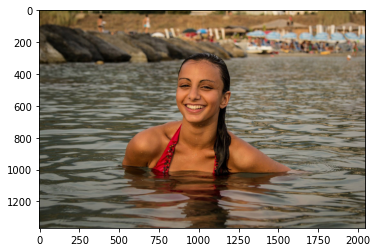

In [4]:
data = image.imread('drive/My Drive/picture.jpg')
print(data.dtype)
print(data.shape)
pyplot.imshow(data)
pyplot.show()

In [5]:
# The data type (UINT8) is suggesting that every pixel is encoded as a sequence of 8 bits
pixel = 8
channels = 3
width = 2048
height = 1366 
dimension = pixel*channels*width*height 
print("The dimension then is ", dimension, " bits")

The dimension then is  67141632  bits


### FFT compressing

In [0]:
from scipy import fftpack as fp
from matplotlib.colors import LogNorm
from PIL import Image

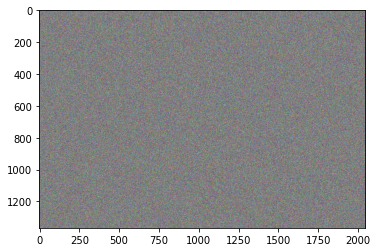

In [7]:
spectrum = fp.rfft((fp.rfft(data, axis=0)), axis=1)
pyplot.imshow(spectrum.astype("uint8"))

We'll first apply a **low pass filter** by masking everything in the spectrum which is not at the top-left corner

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


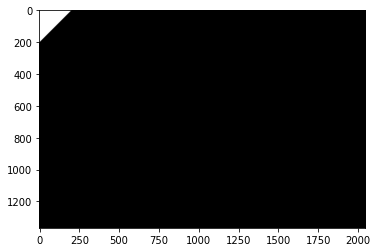

In [11]:
keep = 0.1
dim0_keep = int(keep*spectrum.shape[0])
dim1_keep = int(keep*spectrum.shape[1])
dim_keep = max(dim1_keep,dim0_keep)
lpmask = np.zeros(shape=spectrum.shape)
for i in range(dim_keep):
  for j in range(dim_keep):
    if i+j < dim_keep:
      lpmask[i,j] = 1
pyplot.imshow(lpmask*255)

In [74]:
#let's calculate the fraction of data that we're keeping 
np.sum(lpmask)/(3*spectrum.shape[0]*spectrum.shape[1])

0.00747434914897511

So we're keeping 0.7% of the original data.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


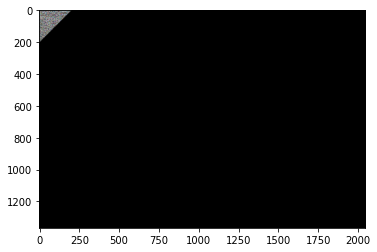

In [16]:
lp_spectrum = np.multiply(spectrum,lpmask)
pyplot.imshow(lp_spectrum)

Now let's try to get back the original image with the inverse transform

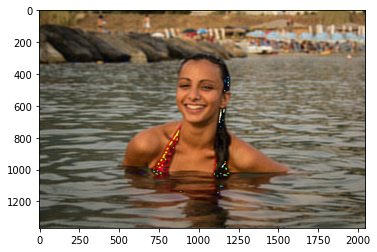

In [17]:
reconstructed = fp.irfft(fp.irfft(lp_spectrum, axis=1),axis=0)
pyplot.imshow(reconstructed.astype("uint8"))

We got it back almost exactly (using 0.7% of the original frequency data)!


Now let's try with another filter: a **band-pass filter**, which only keeps a specific band of frequencies.

In [0]:
r, c, _ = spectrum.shape

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


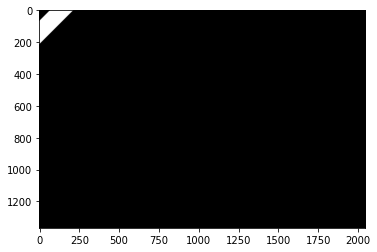

In [75]:
low = 0.05
high = 0.105
low0 = int(low*r)
high0 = int(high*r)
low1 = int(low*c)
high1 = int(high*c)
low = min(low0,low1)
high = max(high0, high1)
bpmask = np.zeros(shape=spectrum.shape)
for i in range(high):
  for j in range(high):
    if i+j < high and i+j > low:
      bpmask[i,j] = 1
pyplot.imshow(bpmask*255)

In [73]:
#let's calculate the fraction of data that we're keeping 
np.sum(bpmask)/(3*r*c)

0.007436816549231332

This time we're saving the same amount of data that we previously saved. Let's look at the result.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


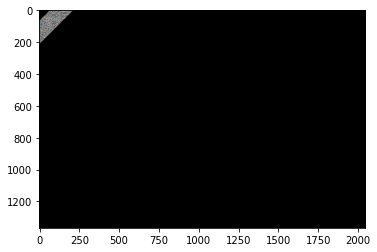

In [42]:
bp_spectrum = np.multiply(spectrum,bpmask)
pyplot.imshow(bp_spectrum)

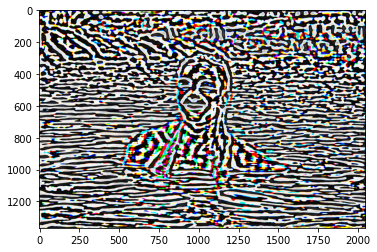

In [43]:
reconstructed = fp.irfft(fp.irfft(bp_spectrum, axis=1),axis=0)
pyplot.imshow(reconstructed.astype("uint8"))

Amazing! At first look it might seem that we're just getting noise back but actually by discarding the low frequencies we're applying a filter that only detects the areas where the image changes at a non constant rate (frequency >> 0) , and hence we're able to detect the "edges" of the image. 

To make this effect even more extreme we'll use an **high-pass filter**, which basically selects all the frequencies above a certain threshold. 

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


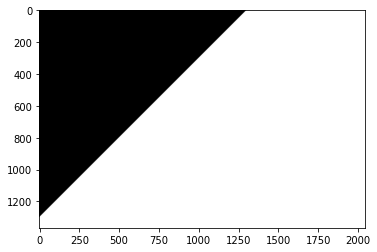

In [78]:
low = 0.95
low0 = int(low*r)
low1 = int(low*c)
low_pass = min(low0,low1)
hpmask = np.zeros(shape=spectrum.shape)
for i in range(r):
  for j in range(c):
    if i+j > low_pass:
      hpmask[i,j] = 1
pyplot.imshow(hpmask*255)

In [79]:
#let's calculate the fraction of data that we're keeping 
np.sum(hpmask)/(3*r*c)

0.6986486119372255

Note: we're now saving a much higher portion of the spectrum. Will this lead to higher accuracy?

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


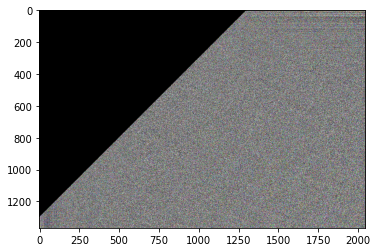

In [80]:
hp_spectrum = np.multiply(spectrum,hpmask)
pyplot.imshow(hp_spectrum)

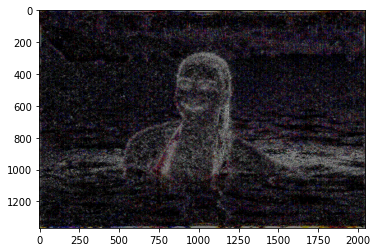

In [81]:
reconstructed = fp.irfft(fp.irfft(hp_spectrum, axis=1),axis=0)
pyplot.imshow(reconstructed.astype("uint8"))

We lost almost all the information! Why? Because we're now able to detect only those part of the original image that change really fast.

## DCT compression 

Instead of using the Fourier basis we'll now adopt the cosine DCT basis, which makes the same periodicity assumptions as the FT but turns out to be more suited to image compression since it can "compact the energy" much more efficiently.